###Feature Selection

In [ ]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Cell 2: Load cleaned dataset (not PCA version, use raw cleaned)
df = pd.read_csv("heart_disease_cleaned.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (303, 19)


,age,trestbps,chol,thalach,oldpeak,ca,target,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,-0.711131,0,True,False,False,False,True,False,True,False,False,True,True,False
1,1.392002,1.611220,0.760415,-1.821905,0.397182,2.504881,1,True,False,False,True,False,False,True,True,True,False,False,False
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1.432877,1,True,False,False,True,False,False,True,True,True,False,False,True
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,-0.711131,0,True,False,True,False,False,False,False,False,False,True,False,False
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,-0.711131,0,False,True,False,False,False,False,True,False,False,False,False,False


In [ ]:
# Cell 3: Split into features (X) and target (y)
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (303, 18)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64


Top 15 features by Random Forest:
 ['thal_7.0', 'thalach', 'ca', 'oldpeak', 'chol', 'cp_4.0', 'age', 'trestbps', 'exang_1.0', 'slope_2.0', 'sex_1.0', 'restecg_2.0', 'cp_3.0', 'cp_2.0', 'fbs_1.0']


/tmp/ipython-input-7808008.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


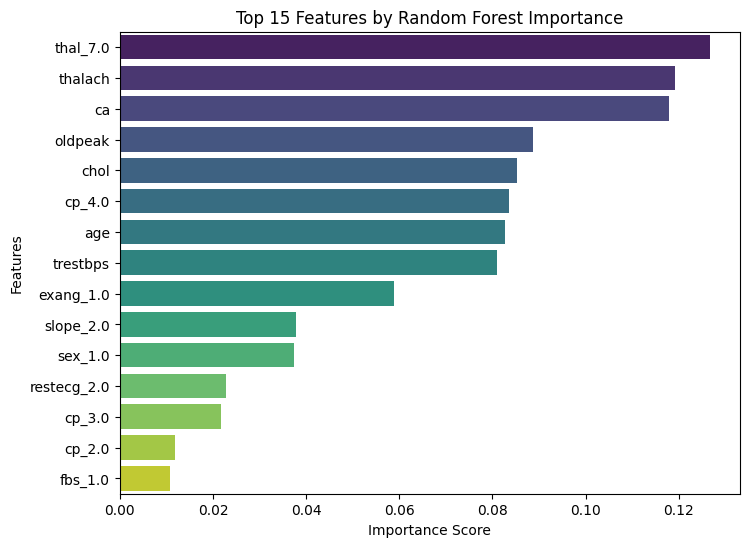

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf_features = list(pd.Series(rf.feature_importances_, index=X.columns)
                   .sort_values(ascending=False)
                   .head(15)
                   .index)

print("Top 15 features by Random Forest:\n", rf_features)
# Visualization of top 15 features
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Top 15 Features by Random Forest Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:
log_reg = LogisticRegression(max_iter=500, solver="liblinear")
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_train, y_train)

rfe_features = list(X.columns[rfe.support_])
print("Top 10 features by RFE:\n", rfe_features)


Top 10 features by RFE:
 ['trestbps', 'thalach', 'ca', 'sex_1.0', 'cp_3.0', 'cp_4.0', 'restecg_2.0', 'exang_1.0', 'slope_2.0', 'thal_7.0']


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_train_scaled, y_train)

chi2_features = list(X_train.columns[chi2_selector.get_support()])
print(" Top 10 features by Chi-Square:\n", chi2_features)


 Top 10 features by Chi-Square:
 ['oldpeak', 'ca', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_2.0', 'exang_1.0', 'slope_2.0', 'thal_7.0']


In [ ]:
selected_features = list(set(rf_features) & set(rfe_features) & set(chi2_features))
print("Final Selected Features (Intersection):\n", selected_features)


Final Selected Features (Intersection):
 ['cp_3.0', 'thal_7.0', 'restecg_2.0', 'exang_1.0', 'ca', 'sex_1.0', 'slope_2.0', 'cp_4.0']


/tmp/ipython-input-1192376311.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_importances.values, y=final_importances.index, palette="mako")


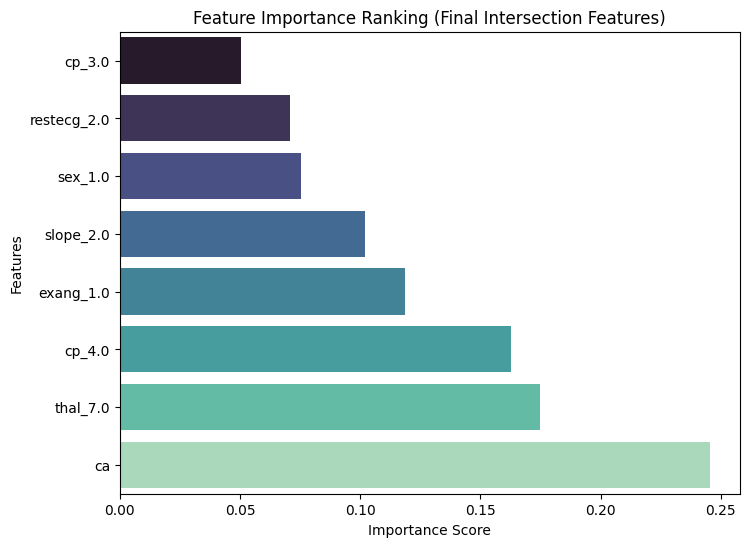

In [ ]:
# Filter importances for intersection features only
# final_features = ['thal_7.0', 'cp_4.0', 'ca', 'oldpeak',
#                   'cp_3.0', 'exang_1.0', 'slope_2.0',
#                   'restecg_2.0', 'sex_1.0']

rf_final = RandomForestClassifier(random_state=42)
rf_final.fit(df[selected_features], df["target"])

final_importances = pd.Series(rf_final.feature_importances_, index=selected_features)
final_importances = final_importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=final_importances.values, y=final_importances.index, palette="mako")
plt.title("Feature Importance Ranking (Final Intersection Features)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:
# Convert boolean to integers (0/1)
df_reduced = df_reduced.astype(int)


In [ ]:
# Build reduced dataset with only the selected features + target
df_reduced = df[selected_features + ["target"]].astype(int)

# Save to CSV
df_reduced.to_csv("heart_disease_reduced.csv", index=False)

# Download to your computer
from google.colab import files
files.download("heart_disease_reduced.csv")

print("Reduced dataset saved as heart_disease_reduced.csv and downloaded")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reduced dataset saved as heart_disease_reduced.csv and downloaded


In [ ]:
df_pca = pd.read_csv("heart_disease_pca.csv")
df_pca.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target
0,0.676405,0.319590,1.270665,-0.096692,-0.361208,1.153790,-0.159689,-0.374035,0.400651,-1.047950,0
1,3.572150,0.514502,-0.193017,-0.631046,0.656140,-1.232756,0.434331,-0.399485,0.124353,-0.109540,1
2,2.405766,-1.235069,-0.591907,-0.007471,0.536252,0.496270,-0.720276,-0.042390,0.408577,0.185984,1
3,-1.333335,-0.270879,1.217331,2.760848,0.327823,1.235111,0.682292,0.219188,-0.196747,-0.386446,0
4,-1.749047,-0.297234,0.861066,0.779096,0.263300,0.187343,0.300309,-1.020257,-0.065941,-0.354516,0


In [ ]:
df_reduced = pd.read_csv("heart_disease_reduced.csv")
df_reduced.head()

,cp_3.0,thal_7.0,restecg_2.0,exang_1.0,ca,sex_1.0,slope_2.0,cp_4.0,target
0,0,0,1,0,0,1,0,0,0
1,0,0,1,1,2,1,1,1,1
2,0,1,1,1,1,1,1,1,1
3,1,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0


Although PCA achieves dimensionality reduction, the project requires interpretable features for modeling. Therefore, supervised and unsupervised learning algorithms will be trained on the reduced dataset obtained from feature selection